In [1]:
!pip install -q transformers torch pillow requests matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.3 MB/s eta 0:00:00


In [2]:
from transformers import AutoFeatureExtractor, CvtForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
import random
from io import BytesIO

In [7]:
CAT_API_SOURCES = [
    "https://cataas.com/cat?width=600&height=600",
    "https://api.thecatapi.com/v1/images/search?size=full",
    "https://placekitten.com/{width}/{height}",
    "https://aws.random.cat/meow",
    "https://purr.objects-us-east-1.dream.io/i/{random}.jpg",
    "https://loremflickr.com/800/800/cat"
]

In [9]:
def get_random_cat_image():
    source = random.choice(CAT_API_SOURCES)

    try:
        if "placekitten" in source:
            width = random.randint(500, 800)
            height = random.randint(500, 800)
            url = source.format(width=width, height=height)
            response = requests.get(url, stream=True, timeout=10)
        elif "thecatapi" in source:
            json_data = requests.get(source, timeout=10).json()
            url = json_data[0]['url']
            response = requests.get(url, stream=True, timeout=10)
        elif "random.cat" in source:
            json_data = requests.get(source, timeout=10).json()
            url = json_data['file']
            response = requests.get(url, stream=True, timeout=10)
        elif "purr.objects-us-east-1" in source:
            random_num = random.randint(1, 1000)
            url = source.format(random=random_num)
            response = requests.get(url, stream=True, timeout=10)
        else:
            response = requests.get(source, stream=True, timeout=10)

        img = Image.open(BytesIO(response.content))

        # Убедимся, что изображение в RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        return img
    except Exception as e:
        print(f"Ошибка при загрузке из {source}: {e}")
        # Возвращаем тестовое изображение кошек по умолчанию
        return Image.open(requests.get(
            "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba",
            stream=True
        ).raw)

In [ ]:
# Загрузка случайного изображения
image = get_random_cat_image()

# Загрузка модели и процессора
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/cvt-13")
model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")

# Подготовка и классификация изображения
inputs = feature_extractor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

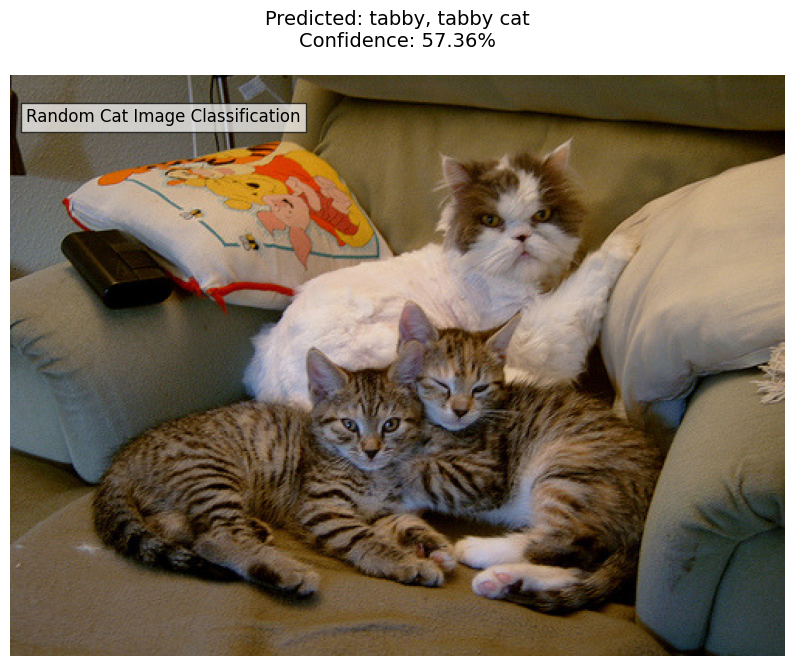

Classification Result:
Predicted class: tabby, tabby cat
Confidence: 57.36%


In [6]:
logits = outputs.logits
probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]
predicted_class_idx = logits.argmax(-1).item()
predicted_label = model.config.id2label[predicted_class_idx]
confidence = round(probabilities[predicted_class_idx].item() * 100, 2)

# Визуализация результатов
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence}%",
          fontsize=14, pad=20)
plt.axis('off')

# Добавляем дополнительную информацию
plt.text(10, 30, "Random Cat Image Classification",
         bbox=dict(facecolor='white', alpha=0.7), fontsize=12)

plt.show()

# Вывод в консоль
print("="*50)
print(f"Classification Result:")
print(f"Predicted class: {predicted_label}")
print(f"Confidence: {confidence}%")
print("="*50)